In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, lines as mlines, patches as mpatches, cm, text as mtext
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import geopandas as gpd
from os import listdir
from shapely.ops import unary_union
from adjustText import adjust_text

In [2]:
filepaths = [f"../data/chicago_city_limits/{file}" for file in listdir("../data/chicago_city_limits")]
city_limits = []
for file in filepaths:
    gdf = gpd.read_file(file)
    gdf['YEAR'] = int(file.split("_")[-1])
    city_limits.append(gdf)
    
city_limits = pd.concat(city_limits, ignore_index=True)
city_limits.sort_values(by='YEAR', inplace=True, ascending=True)

In [3]:
purchases = gpd.read_file("../data/chicago_purchases.geojson")
chicago_border = gpd.read_file("../data/chicago_border.geojson")
cook_county = gpd.read_file("../data/cook_county_with_geometries5.geojson")
dupage_county = gpd.read_file("../data/dupage_county_with_geometries.geojson")
will_county = gpd.read_file("../data/will_county_with_geometries.geojson")
sections = gpd.read_file("../data/sections.json")
dupage_sections = gpd.read_file("../data/dupage_county.json")
will_sections = gpd.read_file("../data/will_county.json")
dupage_section = gpd.read_file("../data/dupage_county.json")
plots = gpd.read_file("../data/lots2.geojson")
settlements = gpd.read_file("../data/settlements.json")
settlements_data = pd.read_csv("../data/settlements_data.csv")
indigenous_camps = gpd.read_file("../data/indigenous_camps.json")
indigenous_villages = gpd.read_file("../data/indigenous_villages.json")
lake = gpd.read_file("../data/lake_michigan.json")

In [4]:
for df in [dupage_county, will_county]:
    df.rename(inplace=True, columns={'Year': "YEAR"})

In [5]:
will_county = will_county.loc[will_county['Township'].isin(['35N', '36N', '37N'])]
will_sections = will_sections.loc[will_sections["TWPNUM"] > 34]

In [6]:
all_purchases = gpd.GeoDataFrame(pd.concat([cook_county, dupage_county, will_county], ignore_index=True))
all_sections = gpd.GeoDataFrame(pd.concat([sections, dupage_sections, will_sections], ignore_index=True))

In [7]:
purchases = purchases.to_crs("EPSG:26916")
all_purchases = all_purchases.to_crs("EPSG:26916")
all_sections = all_sections.to_crs("EPSG:26916")
settlements = settlements.to_crs("EPSG:26916")
chicago_border = chicago_border.to_crs("EPSG:26916")
sections = sections.to_crs("EPSG:26916")
plots = plots.to_crs("EPSG:26916")
indigenous_camps = indigenous_camps.to_crs("EPSG:26916")
indigenous_villages = indigenous_villages.to_crs("EPSG:26916")
lake = lake.to_crs("EPSG:26916")

In [8]:
blues3 = cm.get_cmap('Blues_r', 4)
blues3 = blues3(np.linspace(0, 1, 4))[:-1]
cmap_blues3 = ListedColormap(blues3)
reds3 = cm.get_cmap('Reds_r', 4)
reds3 = reds3(np.linspace(0, 1, 4))[:-1]
cmap_reds3 = ListedColormap(reds3)
greens3 = cm.get_cmap('Greens_r', 4)
greens3 = greens3(np.linspace(0, 1, 4))[:-1]
cmap_greens3 = ListedColormap(greens3)
lake_color = "lightblue"
background_color = "#ECECEC"
chi_color = "blue"

In [9]:
chiminx, chiminy, chimaxx, chimaxy = chicago_border.total_bounds
spacer = 1000
chi_framex = (chiminx-spacer, chimaxx+spacer)
chi_framey = (chiminy-spacer, chimaxy+spacer)
allminx, allminy, allmaxx, allmaxy = all_sections.total_bounds
all_framex = (allminx, allmaxx)
all_framey = (allminy, allmaxy)

In [10]:
def plot_lake(ax):
    lake.plot(ax=ax, color=lake_color)
    
def set_background(ax, larger_area=False):
    if larger_area:
        ax.set_xlim(all_framex)
        ax.set_ylim(all_framey)
    else:
        ax.set_xlim(chi_framex)
        ax.set_ylim(chi_framey)
        
    ax.set_facecolor(background_color)
    
def plot_purchases(ax, year_breaks=None, categorical=False):
     purchases[(purchases['YEAR'] <= year)].plot(column="YEAR",ax=axes[idx], cmap="Greens_r", vmin=1820, vmax=1890)

In [11]:
sections = sections.overlay(chicago_border, how='intersection')
plots = plots.overlay(chicago_border, how='intersection')
indigenous_camps = indigenous_camps.sjoin(chicago_border, predicate="within")
indigenous_villages = indigenous_villages.sjoin(chicago_border, predicate="intersects")

In [12]:
settlements = settlements.merge(settlements_data, on="settlement", how="left")
settlements.sort_values(by=['settled'], inplace=True)
settlements.reset_index(drop=True,inplace=True)

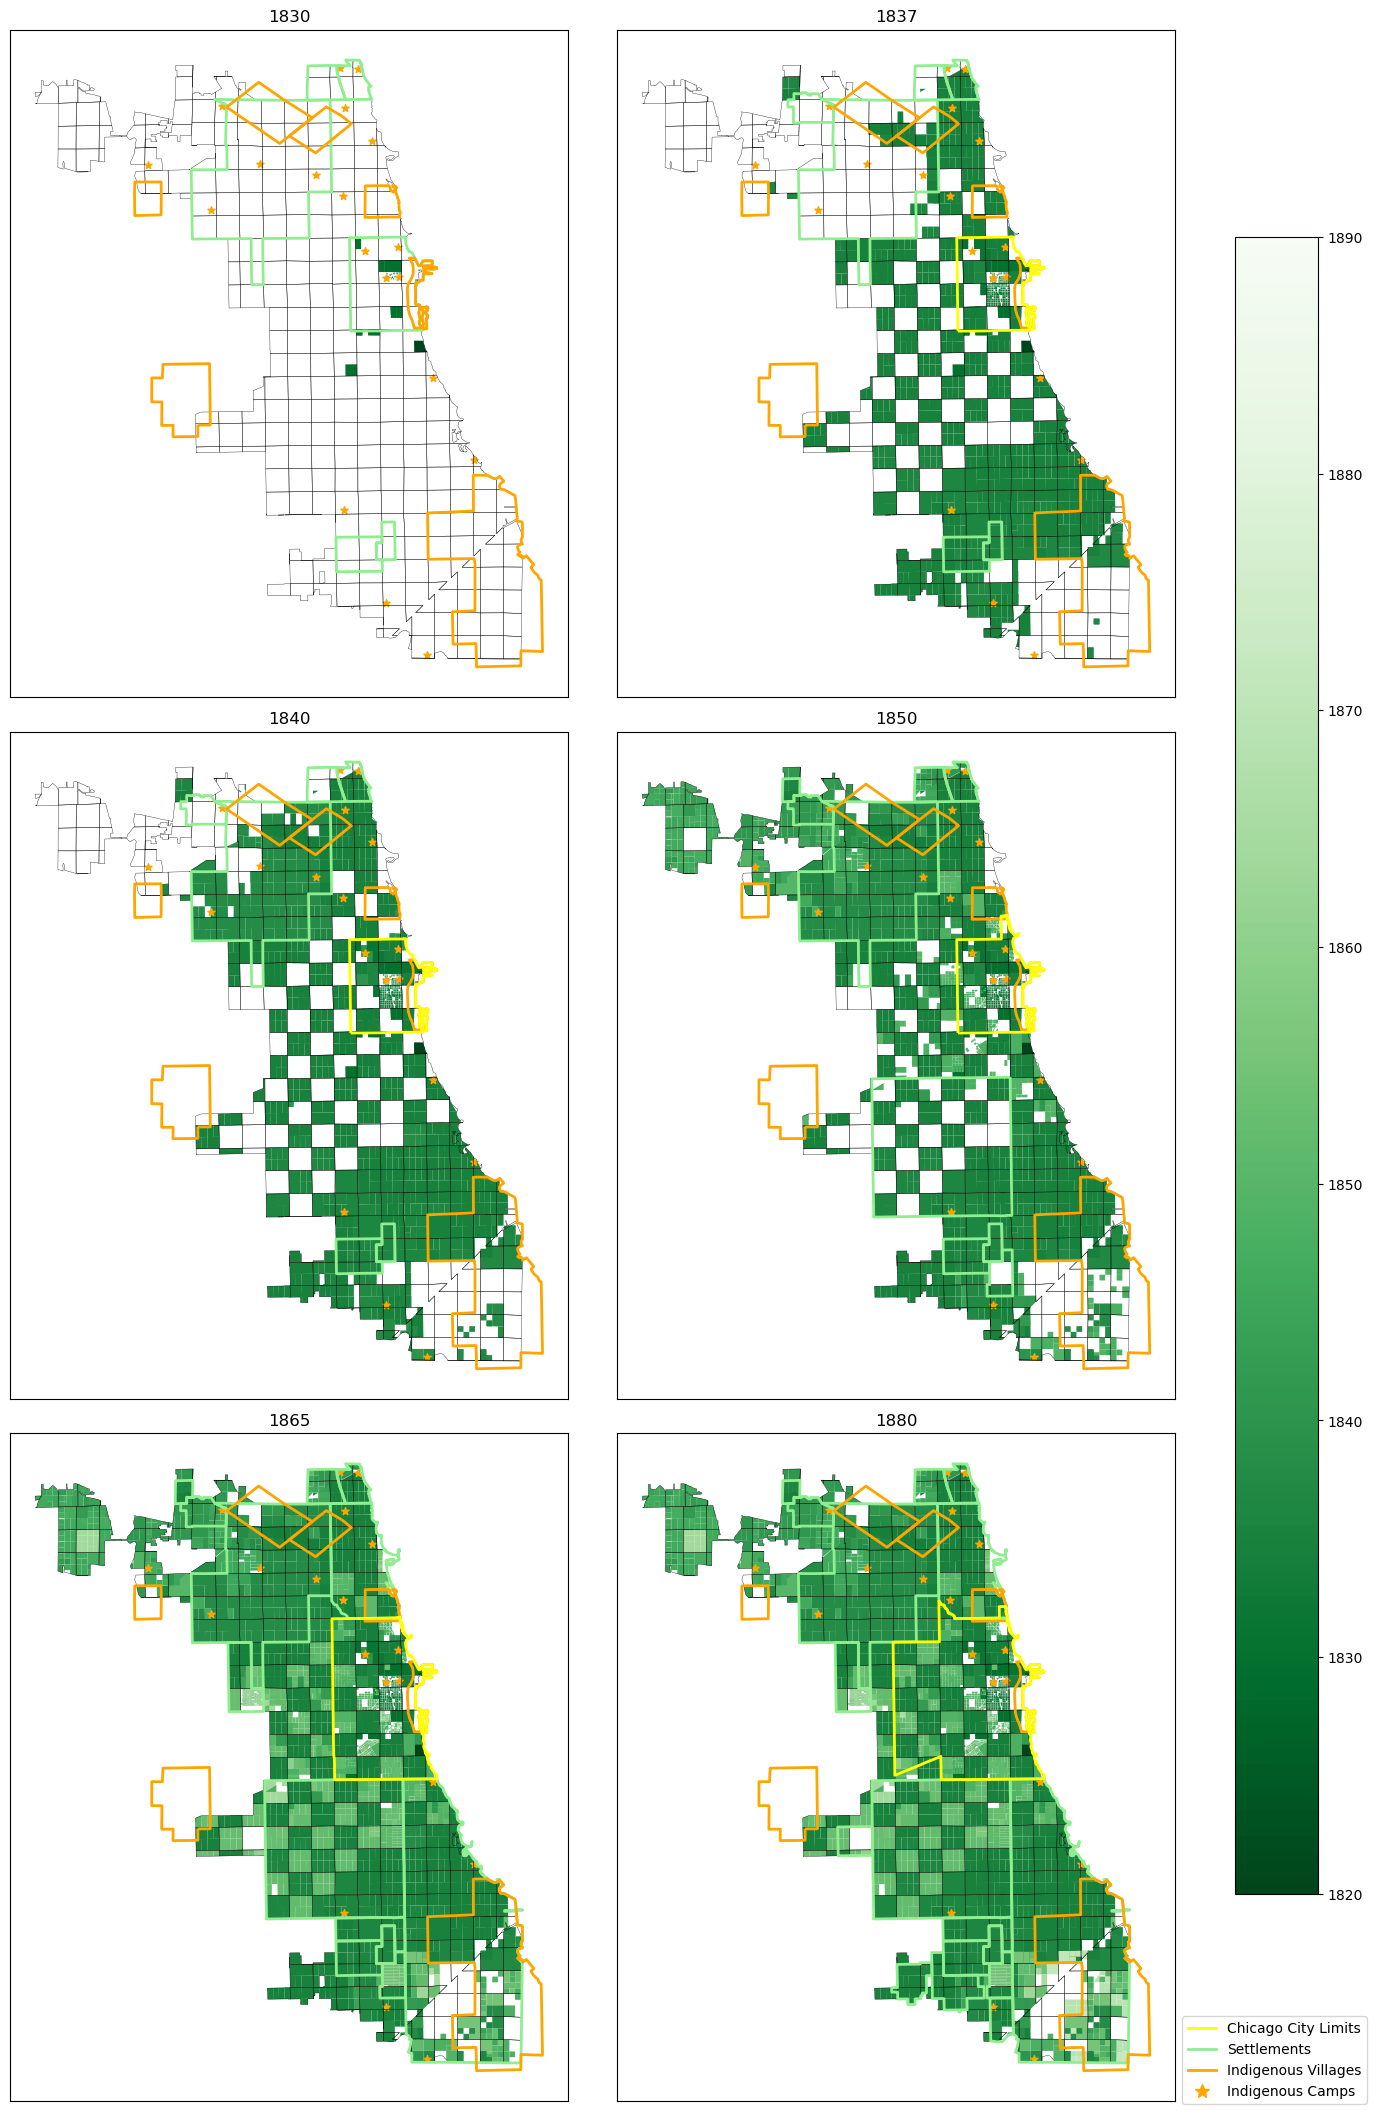

In [13]:
year_breaks = [1830, 1837, 1840, 1850, 1865, 1880]
settlements.loc[settlements['settlement'] == 'CHICAGO', 'annexed'] = 1837

plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

fig, axes = plt.subplots(3, 2, figsize=(14,21), layout="constrained")
axes = axes.flatten()


for idx, year in enumerate(year_breaks):
    purchases[(purchases['YEAR'] <= year)].plot(column="YEAR",\
                                                        ax=axes[idx], cmap="Greens_r", vmin=1820, vmax=1890)
    sections.boundary.plot(ax=axes[idx], edgecolor='black', linewidth=0.25)
    
    settlement_line = settlements[(settlements['settled'] <= year)&(settlements['annexed'] > year)].boundary.plot(ax=axes[idx], edgecolor='lightgreen', linewidth=2)
    
    current_city = city_limits[(city_limits['YEAR'] <= year)]
    indigenous_village_line = indigenous_villages.boundary.plot(ax=axes[idx], edgecolor="orange", linewidth=2)
    indigenous_camp_markers = indigenous_camps.plot(ax=axes[idx], marker='*', color='orange', markersize=30,)
    axes[idx].set_title(year)
    
    if len(current_city) > 0:
        city_limit_line = current_city[current_city['YEAR'] == current_city['YEAR'].max()].boundary.plot(ax=axes[idx], edgecolor='yellow', linewidth=2,)
    
patch_col = axes[0].collections[0]


cb = fig.colorbar(patch_col, ax=axes, shrink=0.8)
city_limit_line = mlines.Line2D([], [], color='yellow', label='Chicago City Limits', linewidth=2)
settlement_line = mlines.Line2D([], [], color='lightgreen', label='Settlements', linewidth=2)
indigenous_village_line = mlines.Line2D([], [], color='orange', label='Indigenous Villages', linewidth=2)
indigenous_camp_markers = mlines.Line2D([], [], color="orange", linestyle='None', marker="*", markersize="10", label="Indigenous Camps")

fig.legend(handles=[city_limit_line, settlement_line, indigenous_village_line, indigenous_camp_markers], loc=4)


fig.savefig('../results/timeseries.png')

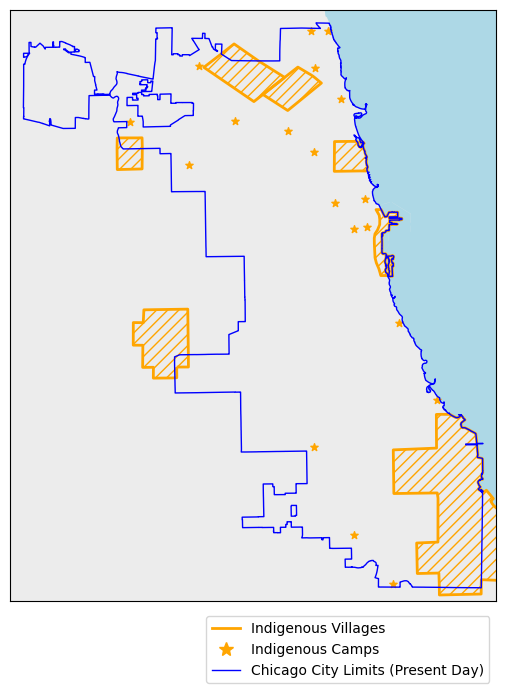

In [14]:
fig, ax = plt.subplots(figsize=(5,6), layout="constrained")

plot_lake(ax)
indigenous_villages.boundary.plot(ax=ax, edgecolor="orange", linewidth=2, color="orange", hatch = "///")
indigenous_camps.plot(ax=ax, marker='*', color='orange', markersize=30,)
chicago_border.boundary.plot(ax=ax, linewidth=1, edgecolor=chi_color)
indigenous_village_line = mlines.Line2D([], [], color='orange', label='Indigenous Villages', linewidth=2)
indigenous_camp_markers = mlines.Line2D([], [], color="orange", linestyle='None', marker="*", markersize="10", label="Indigenous Camps")
chicago_border_line = mlines.Line2D([], [], label='Chicago City Limits (Present Day)', linewidth=1, color=chi_color)

set_background(ax)

fig.legend(handles=[indigenous_village_line, indigenous_camp_markers, chicago_border_line], loc=4, bbox_to_anchor=(1, -0.15), bbox_transform=ax.transAxes)
fig.savefig('../results/fig1_indigenous_land.png', bbox_inches='tight', dpi=100)

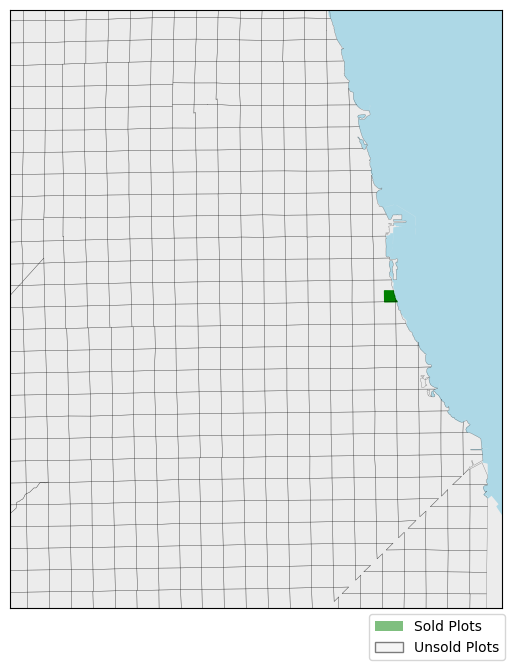

In [15]:
fig, ax = plt.subplots(figsize=(5,7.1), layout="constrained")
plot_lake(ax)
all_purchases[(all_purchases['YEAR'] <= 1822)].plot(ax=ax, edgecolor="green", color="green", label="Plots Sold")
all_sections.plot(ax=ax, edgecolor="black", linewidth=0.25, color="none", alpha=0.5, label="Unsold Plots",)
sold_lots = mpatches.Rectangle((0, 0), 1, 1, fc="green",alpha=0.5, label="Sold Plots")
unsold_lots = mpatches.Rectangle((0, 0), 1, 1, fc=background_color, ec="black", alpha=0.5, label="Unsold Plots")
set_background(ax)
fig.legend(handles=[sold_lots, unsold_lots], loc=4)

fig.savefig('../results/fig2_vacant_lots_1822.png')

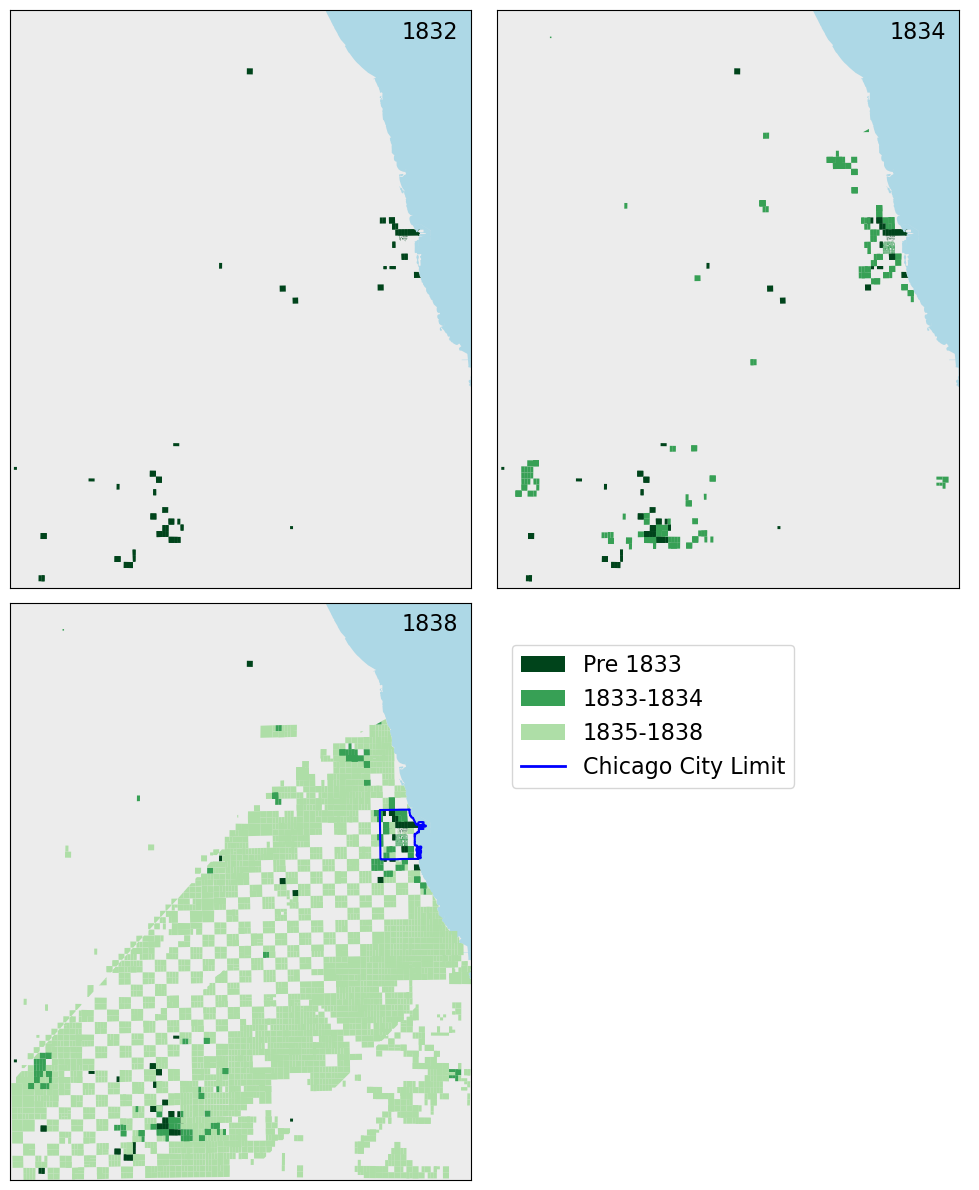

In [16]:
year_breaks = [1832, 1834, 1838]

plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

fig, axes = plt.subplots(2, 2, figsize=(10,12), layout="tight")
axes = axes.flatten()


for idx, year in enumerate(year_breaks):
    lake.plot(ax=axes[idx], color=lake_color)
    all_purchases[(all_purchases['YEAR'] <= year)].plot(column="YEAR", cmap=cmap_greens3,\
                                                        ax=axes[idx], scheme='user_defined', classification_kwds={'bins': year_breaks})

    current_city = city_limits[(city_limits['YEAR'] <= year)]
    if len(current_city) > 0:
        city_limit_line = current_city[current_city['YEAR'] == current_city['YEAR'].max()].boundary.plot(ax=axes[idx], edgecolor=chi_color, linewidth=1.5)
     
    axes[idx].text(.85, .95, year, transform=axes[idx].transAxes, fontsize=16)
    
    set_background(axes[idx], True)



axes[-1].axis("off")

handles = []
for c in greens3:
    handles.append(mpatches.Rectangle((0, 0), 1, 1, fc=c[:-1],alpha=1))
    
city_limit_line = mlines.Line2D([], [], color=chi_color, linewidth=2)
handles.append(city_limit_line)
fig.legend(handles=handles, labels=['Pre 1833', '1833-1834','1835-1838','Chicago City Limit'], fontsize=16, loc=4, bbox_to_anchor=(0.66, 0.66), bbox_transform=axes[3].transAxes)
fig.savefig('../results/fig3_timeseries_1830s.png', bbox_inches='tight', dpi=100)

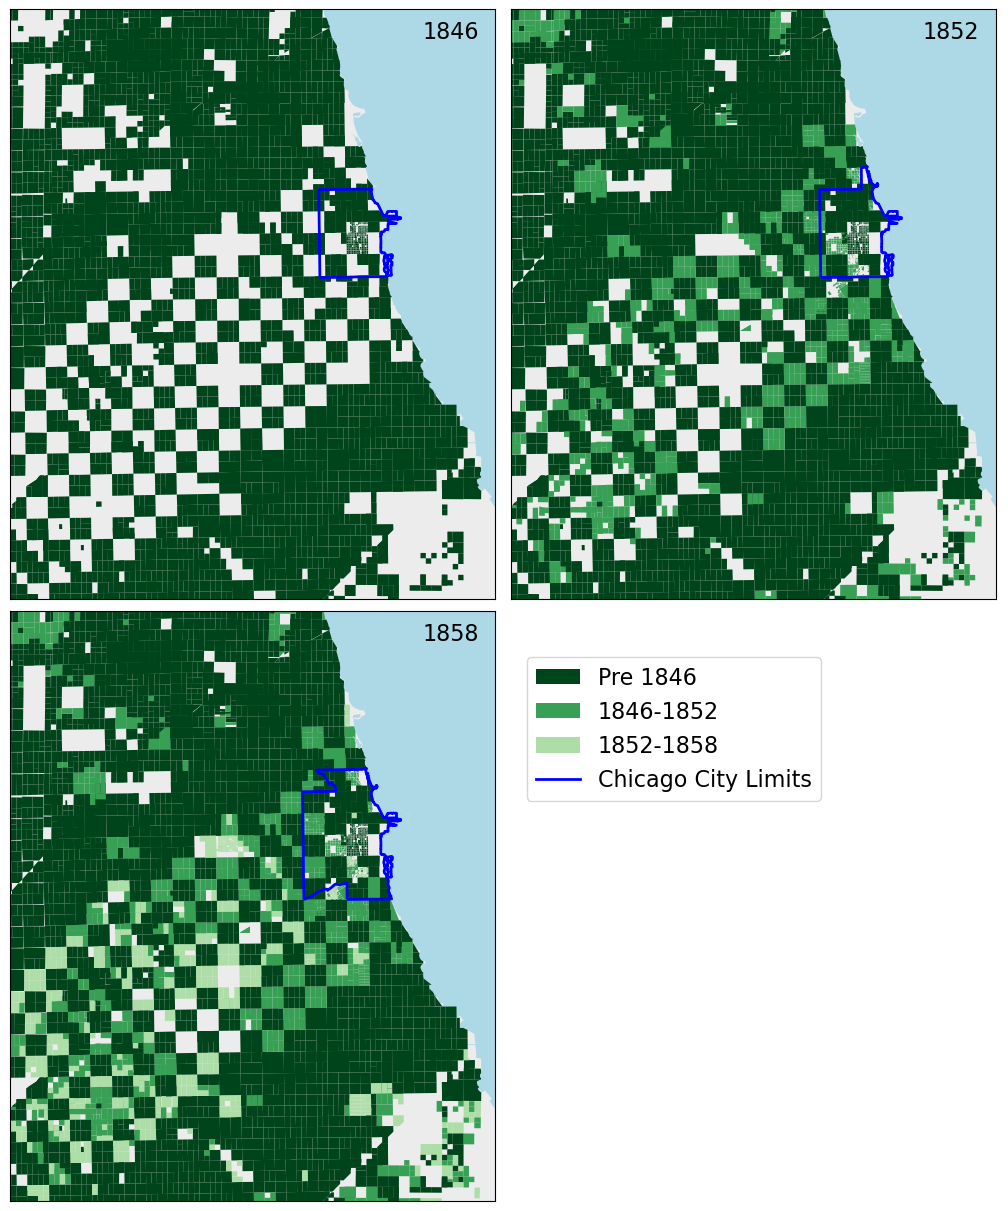

In [17]:
year_breaks = [1846, 1852, 1858]
labels = []

for i, year in enumerate(year_breaks):
    prefix = "Pre "
    if i != 0:
        prefix = f"{year_breaks[i-1]}-"
    
    labels.append(prefix + str(year))
        

plasma = cm.get_cmap('plasma', 10)
newcolors = plasma(np.linspace(0, 1, 10))
# gray = np.array([180/256, 180/256, 180/256, 0.5])
# newcolors[0, :] = gray
newcmp = ListedColormap(newcolors)

plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

fig, axes = plt.subplots(2, 2, figsize=(10,12), layout="constrained")
axes = axes.flatten()


for idx, year in enumerate(year_breaks):
    plot_lake(axes[idx])
    all_purchases[(all_purchases['YEAR'] <= year)].plot(column="YEAR", cmap=cmap_greens3,\
                                                        ax=axes[idx], scheme='user_defined', classification_kwds={'bins': year_breaks})
    current_city = city_limits[(city_limits['YEAR'] <= year)]
    if len(current_city) > 0:
        city_limit_line = current_city[current_city['YEAR'] == current_city['YEAR'].max()].boundary.plot(ax=axes[idx], edgecolor=chi_color, linewidth=2,)
        
    axes[idx].text(.85, .95, year, transform=axes[idx].transAxes, fontsize=16)
    set_background(axes[idx])
    

axes[3].axis("off")

handles = []
for c in greens3:
    handles.append(mpatches.Rectangle((0, 0), 1, 1, fc=c[:-1],alpha=1))
    
city_limit_line = mlines.Line2D([], [], color=chi_color, linewidth=2)
handles.append(city_limit_line)
labels.append("Chicago City Limits")
fig.legend(handles=handles, labels=labels, fontsize=16, loc=4, bbox_to_anchor=(.66, .66), bbox_transform=axes[3].transAxes)
    
fig.savefig('../results/fig4_timeseries_1840s_60s.png', bbox_inches='tight', dpi=100)

In [18]:
class TextHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        texthandle = mtext.Text(text=orig_handle)

        handlebox.add_artist(texthandle)
        return texthandle

In [19]:
offsets = [(0,0) for _ in range(len(settlements))]

In [20]:
offsets[5] = (0, -300)
offsets[9] = (-1600, 500)
offsets[10] = (-500, 0)
offsets[13] = (0, -1250)
offsets[15] = (0, -200)
offsets[18] = (-1000, -1000)

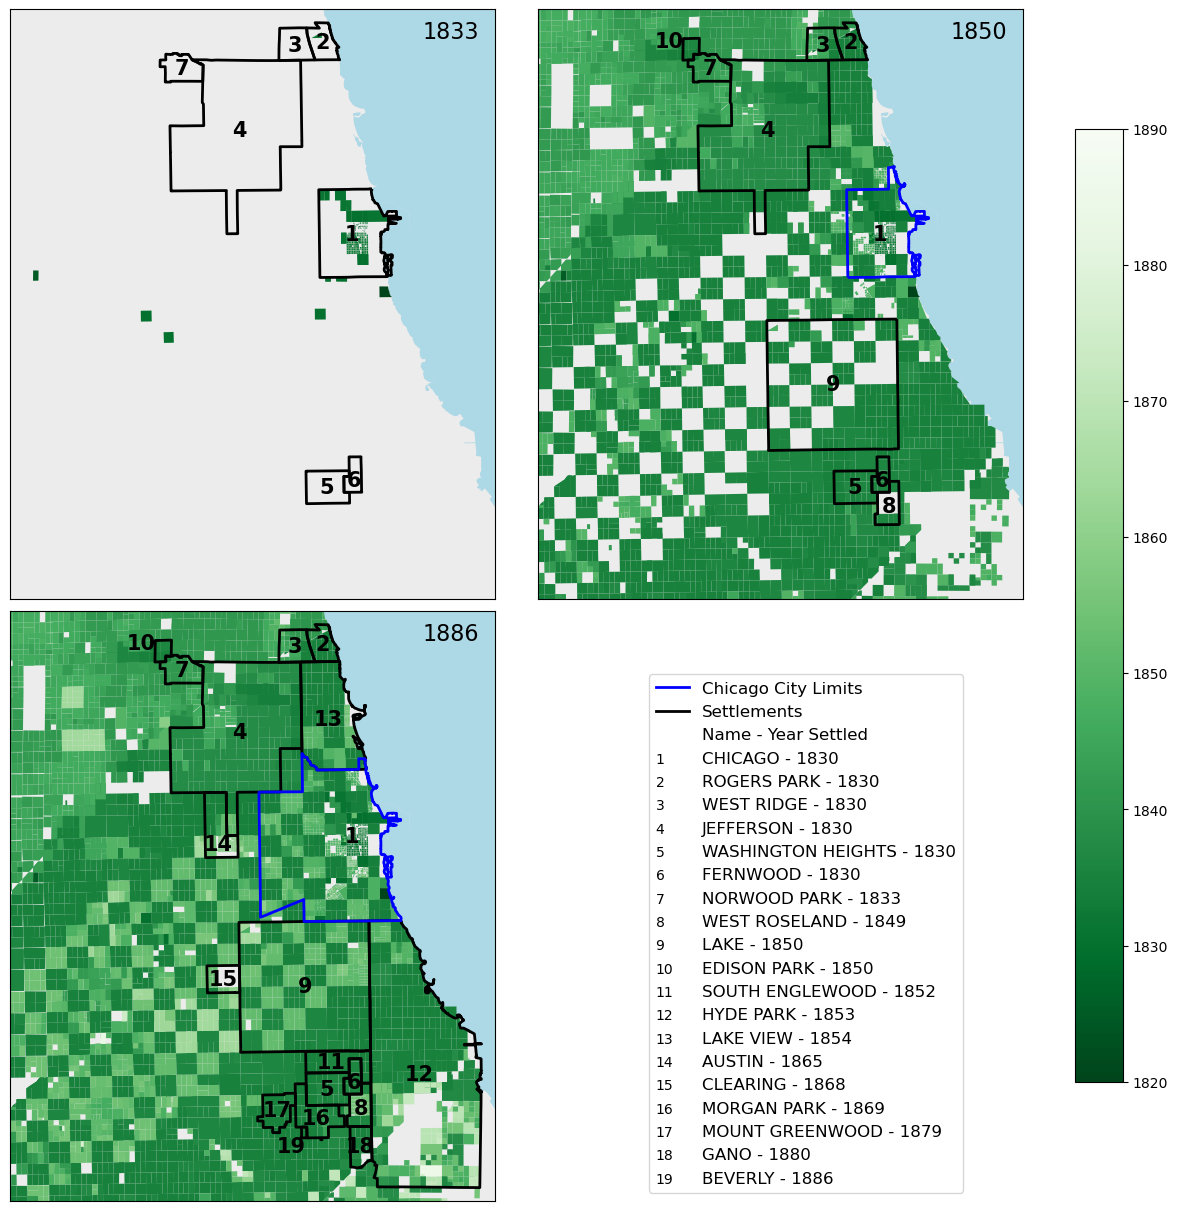

In [21]:
year_breaks = [1833, 1850, 1886]
settlements.loc[settlements['settlement'] == 'CHICAGO', 'annexed'] = 1837

plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

fig, axes = plt.subplots(2, 2, figsize=(12,12), layout="constrained")
axes = axes.flatten()


for idx, year in enumerate(year_breaks):
    plot_lake(axes[idx])
    all_purchases[(all_purchases['YEAR'] <= year)].plot(column="YEAR",\
                                                        ax=axes[idx], cmap="Greens_r", vmin=1820, vmax=1890)    
    settlement_line = settlements[(settlements['settled'] <= year)&(settlements['annexed'] > year)].boundary.plot(ax=axes[idx], edgecolor='black', linewidth=2)
    
    settlements_to_annotate = settlements.loc[(settlements['settled'] <= year)]
    
    
    annotations = []
    for i, settlement in settlements_to_annotate.iterrows():
        x, y = settlement['geometry'].centroid.coords[0]
        t = axes[idx].annotate(str(i + 1), (x + offsets[i][0], y + offsets[i][1]), weight='bold', size=15, va="center", ha="center")
        annotations.append(t)
    
    current_city = city_limits[(city_limits['YEAR'] <= year)]
    axes[idx].text(.85, .95, year, transform=axes[idx].transAxes, fontsize=16)
    set_background(axes[idx])
    

    
    if len(current_city) > 0:
        city_limit_line = current_city[current_city['YEAR'] == current_city['YEAR'].max()].boundary.plot(ax=axes[idx], edgecolor=chi_color, linewidth=2,)
            
patch_col = axes[0].collections[1]


cb = fig.colorbar(patch_col, ax=axes, shrink=0.8)
city_limit_line = mlines.Line2D([], [], color=chi_color, label='Chicago City Limits', linewidth=2)
settlement_line = mlines.Line2D([], [], color='black', label='Settlements', linewidth=2)

axes[-1].axis("off")
handles=[city_limit_line, settlement_line, ""]
labels = ['Chicago City Limits', 'Settlements', 'Name - Year Settled']

for idx, row in settlements.iterrows():
    handles.append(str(idx + 1))
    labels.append(row['settlement'] + " - " + str(int(row['settled'])))

fig.legend(handles=handles, labels=labels, handler_map={str: TextHandler()},\
           fontsize="12", loc=4, bbox_to_anchor=(.9, 0), bbox_transform=axes[3].transAxes)

fig.savefig('../results/fig5_township_formation.png')

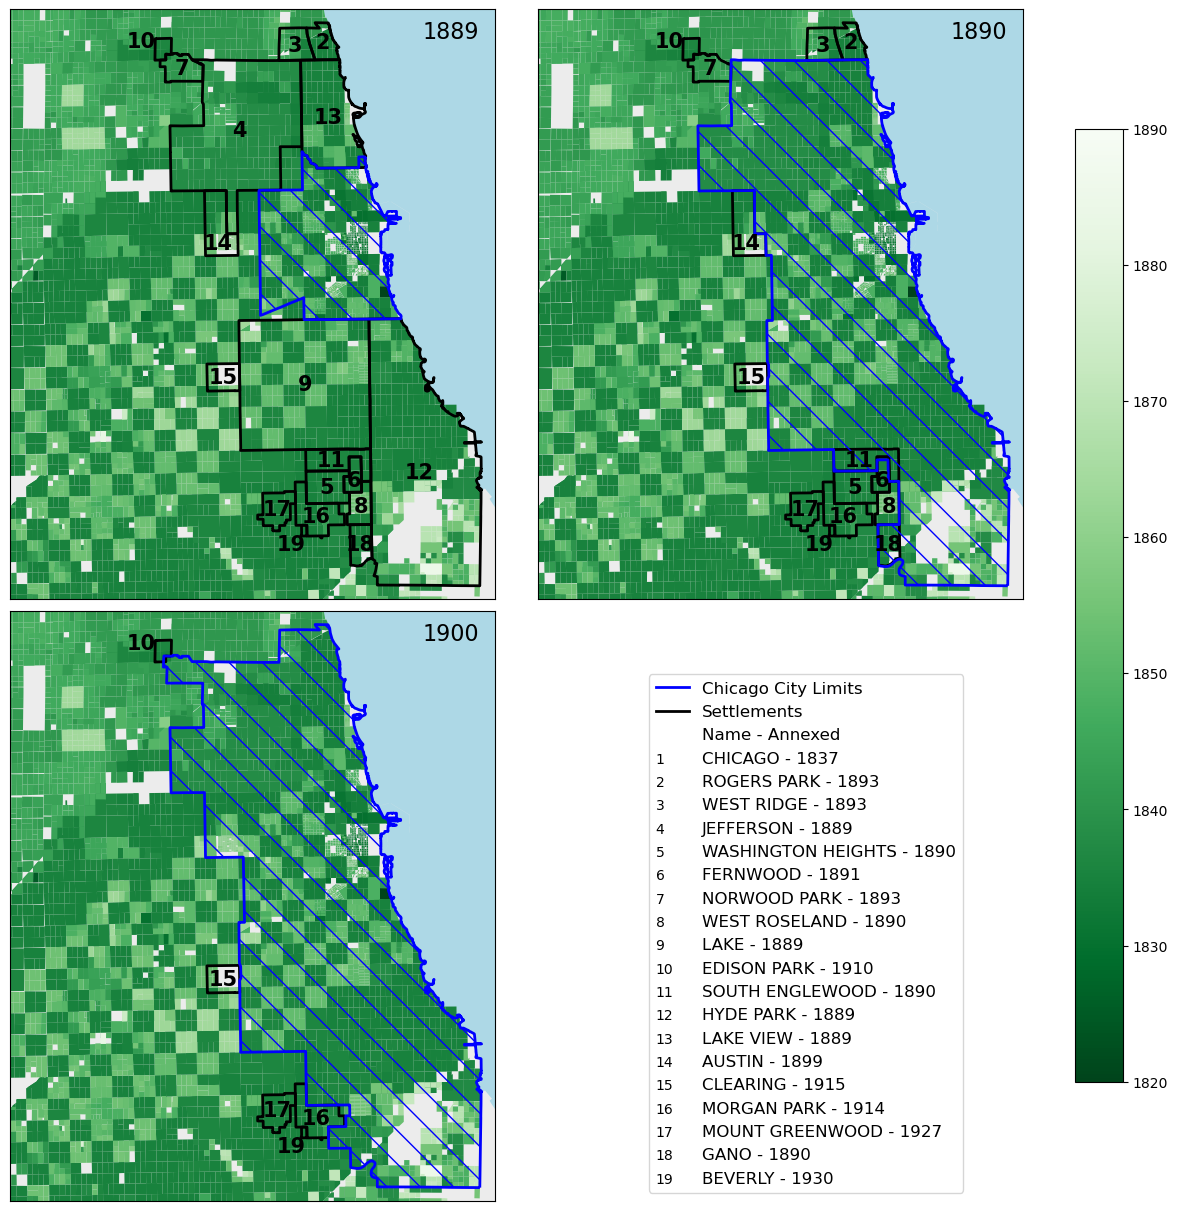

In [22]:
year_breaks = [1889, 1890, 1900]
settlements.loc[settlements['settlement'] == 'CHICAGO', 'annexed'] = 1837

plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

fig, axes = plt.subplots(2, 2, figsize=(12,12), layout="constrained")
axes = axes.flatten()


for idx, year in enumerate(year_breaks):
    plot_lake(axes[idx])
    all_purchases[(all_purchases['YEAR'] <= year)].plot(column="YEAR",\
                                                        ax=axes[idx], cmap="Greens_r", vmin=1820, vmax=1890)    
    settlement_line = settlements[(settlements['settled'] <= year)&(settlements['annexed'] > year - 1)].boundary.plot(ax=axes[idx], edgecolor='black', linewidth=2)
    
    settlements_to_annotate = settlements.loc[(settlements['annexed'] >= year)]
    
    annotations = []
    for i, settlement in settlements_to_annotate.iterrows():
        x, y = settlement['geometry'].centroid.coords[0]
        t = axes[idx].annotate(str(i + 1), (x + offsets[i][0], y + offsets[i][1]), weight='bold', size=15, va="center", ha="center")
        annotations.append(t)
    
    current_city = city_limits[(city_limits['YEAR'] <= year)]
    
    if len(current_city) > 0:
        city_limit_line = current_city[current_city['YEAR'] == current_city['YEAR'].max()].boundary.plot(ax=axes[idx], edgecolor=chi_color, linewidth=2, hatch="\\")
        
    axes[idx].text(.85, .95, year, transform=axes[idx].transAxes, fontsize=16)
    set_background(axes[idx])
            
patch_col = axes[0].collections[1]


cb = fig.colorbar(patch_col, ax=axes, shrink=0.8)
city_limit_line = mlines.Line2D([], [], color=chi_color, label='Chicago City Limits', linewidth=2)
settlement_line = mlines.Line2D([], [], color='black', label='Settlements', linewidth=2)

axes[-1].axis("off")
handles=[city_limit_line, settlement_line, ""]
labels = ['Chicago City Limits', 'Settlements', 'Name - Annexed']

for idx, row in settlements.iterrows():
    handles.append(str(idx + 1))
    labels.append(row['settlement'] + " - " + str(int(row['annexed'])))

fig.legend(handles=handles, labels=labels, handler_map={str: TextHandler()},\
           fontsize=12, loc=4, bbox_to_anchor=(.9, 0), bbox_transform=axes[3].transAxes)


fig.savefig('../results/fig6_annexation.png')

In [23]:
sections.to_crs("wgs84").to_file("../web/chicago_sections.geojson")
indigenous_camps.to_crs("wgs84").to_file("../web/chicago_indigenous_camps.geojson")
indigenous_villages.to_crs("wgs84").to_file("../web/chicago_indigenous_villages.geojson")
city_limits.to_crs("wgs84").to_file("../web/city_limits.geojson")
settlements.to_crs("wgs84").to_file("../web/settlements.geojson")

In [37]:
offsets[1] = (0, 500)
offsets[5] = (0, 0)
offsets[13] = (200, -1250)
offsets[16] = (-500, 500)
offsets[18] = (-800, -800)

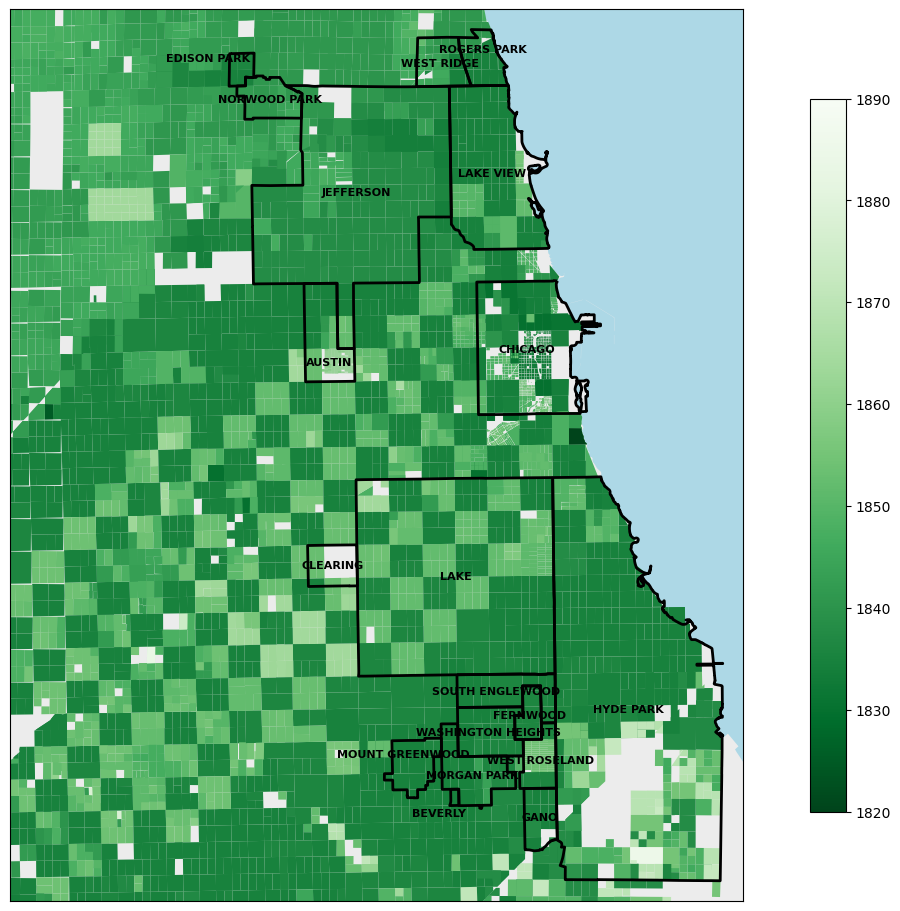

In [41]:
fig, ax = plt.subplots(figsize=(15,9), layout="constrained")

plot_lake(ax)
all_purchases[(all_purchases['YEAR'] <= 1886)].plot(column="YEAR", ax=ax, cmap="Greens_r", vmin=1820, vmax=1890)

annotations = []

settlements.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
for i, settlement in settlements.iterrows():
    x, y = settlement['geometry'].centroid.coords[0]
    an = ax.annotate(settlement['settlement'], (x + offsets[i][0], y + offsets[i][1]), weight="bold", size=8, va="center", ha="center")
    annotations.append(an)
    
set_background(ax)

patch_col = axes[0].collections[1]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.8)

fig.savefig('../results/settlements_annotated.png', bbox_inches='tight', dpi=100)